#Conditional GAN for Microstructure Generation

In [ ]:
!pip install torch torchvision numpy matplotlib tqdm pillow torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 15.2 MB/s eta 0:00:00


Imports & Setup

In [ ]:
import os, glob
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid, save_image

In [ ]:
from PIL import Image
import numpy as np
from tqdm import tqdm

In [ ]:
import torch.nn.functional as F
from torchmetrics.image.fid import FrechetInceptionDistance
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Dataset Preparation(Implement Synthetic Labels)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_root = "/content/drive/MyDrive/GAN/ferritic_steel"

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
class SteelCGANDataset(Dataset):
    def __init__(self, root_dir, num_classes=3, transform=None):
        self.files = sorted(glob.glob(os.path.join(root_dir, "*")))
        self.transform = transform
        self.num_classes = num_classes
        self.labels = np.random.randint(0, num_classes, len(self.files))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("L")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return img, label

In [ ]:
dataset = SteelCGANDataset(data_root, num_classes=3, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)
print(f"Total images: {len(dataset)}")

Total images: 1705


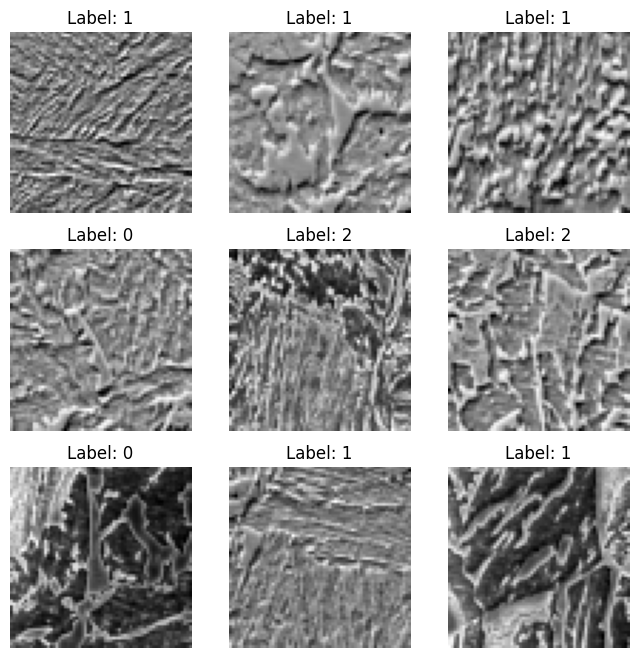

In [ ]:
images, labels = next(iter(dataloader))
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].squeeze().cpu().numpy() * 0.5 + 0.5, cmap="gray")
    plt.title(f"Label: {labels[i].item()}")
    plt.axis("off")
plt.show()

Helper Functions

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

In [ ]:
def one_hot(labels, num_classes, device):
    return F.one_hot(labels, num_classes=num_classes).float().to(device)

Model Definitions

Conditional Generator (concat z + one-hot, CBN optional)

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz=100, nc=1, ngf=64, num_classes=3):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(nz + num_classes, ngf * 8 * 4 * 4),
            nn.BatchNorm1d(ngf * 8 * 4 * 4),
            nn.ReLU(True)
        )
        self.up = nn.Sequential(
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, cond):
        x = torch.cat([z, cond], 1)
        x = self.fc(x).view(-1, 512, 4, 4)
        return self.up(x)

Conditional Discriminator (channel-concat condition map)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64, num_classes=3):
        super().__init__()
        self.num_classes = num_classes
        self.main = nn.Sequential(
            nn.Conv2d(nc + num_classes, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        B, _, H, W = img.size()
        cond = one_hot(labels, self.num_classes, img.device)
        cond_map = cond.view(B, self.num_classes, 1, 1).repeat(1, 1, H, W)
        x = torch.cat([img, cond_map], 1)
        return self.main(x)

Initialize Models

In [ ]:
nz, nc, ngf, ndf, num_classes = 100, 1, 64, 64, 3
G = Generator(nz, nc, ngf, num_classes).to(device)
D = Discriminator(nc, ndf, num_classes).to(device)
G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
z = torch.randn(8, nz, device=device)
labels = torch.randint(0, num_classes, (8,), device=device)
cond = one_hot(labels, num_classes, device)
fake = G(z, cond)
print("fake:", fake.shape)
print("logits:", D(fake, labels).shape)

fake: torch.Size([8, 1, 64, 64])
logits: torch.Size([8, 1, 1, 1])


###PHASE 3 — TRAINING PIPELINE

In [ ]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
base_dir = "/content/drive/MyDrive/GAN/CGAN/final_results"
os.makedirs(base_dir, exist_ok=True)

In [ ]:
fixed_noise = torch.randn(num_classes * 8, nz, device=device)
fixed_labels = torch.tensor([i % num_classes for i in range(num_classes * 8)], device=device)

In [ ]:
!pip install torch-fidelity

In [ ]:
fid_metric = FrechetInceptionDistance(normalize=True).to(device)

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:03<00:00, 27.3MB/s]


Training Loop with FID + Checkpoints + Single Image Save

In [ ]:
num_epochs = 200
fid_scores = []

for epoch in range(num_epochs):
    G.train(); D.train()
    g_loss_total, d_loss_total = 0, 0

    for real_imgs, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        b_size = real_imgs.size(0)
        real_targets = torch.ones(b_size, 1, device=device)
        fake_targets = torch.zeros(b_size, 1, device=device)

        # --- Train D ---
        optimizerD.zero_grad()
        loss_real = criterion(D(real_imgs, labels).view(-1,1), real_targets)
        noise = torch.randn(b_size, nz, device=device)
        fake_imgs = G(noise, one_hot(labels, num_classes, device))
        loss_fake = criterion(D(fake_imgs.detach(), labels).view(-1,1), fake_targets)
        d_loss = loss_real + loss_fake
        d_loss.backward(); optimizerD.step()

        # --- Train G ---
        optimizerG.zero_grad()
        output_fake_for_g = D(fake_imgs, labels)
        g_loss = criterion(output_fake_for_g.view(-1,1), real_targets)
        g_loss.backward(); optimizerG.step()

        d_loss_total += d_loss.item()
        g_loss_total += g_loss.item()

    # --- Epoch Summary ---
    print(f" Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss_total/len(dataloader):.4f} | G Loss: {g_loss_total/len(dataloader):.4f}")

    # --- Save Generated Samples ---
    if (epoch+1) % 10 == 0:
        G.eval()
        epoch_dir = os.path.join(base_dir, f"epoch_{epoch+1}")
        os.makedirs(epoch_dir, exist_ok=True)
        with torch.no_grad():
            fake_imgs = G(fixed_noise, one_hot(fixed_labels, num_classes, device))
            for i, img in enumerate(fake_imgs):
                save_image((img + 1)/2, f"{epoch_dir}/sample_{i+1}.png")
            grid = make_grid(fake_imgs, nrow=8, normalize=True)
            save_image(grid, f"{epoch_dir}/grid_epoch_{epoch+1}.png")
        print(f" Saved individual & grid images for epoch {epoch+1}")

    # --- Compute FID every 10 epochs ---
    if (epoch+1) % 10 == 0:
        fid_metric.reset()
        with torch.no_grad():
            real_batch, _ = next(iter(dataloader))
            real_batch = real_batch.to(device)[:500]
            noise = torch.randn(500, nz, device=device)
            labels_sample = torch.randint(0, num_classes, (500,), device=device)
            fake_batch = G(noise, one_hot(labels_sample, num_classes, device))

            real_batch = real_batch.repeat(1, 3, 1, 1)
            fake_batch = fake_batch.repeat(1, 3, 1, 1)
            fid_metric.update(real_batch, real=True)
            fid_metric.update(fake_batch, real=False)
            fid_score = fid_metric.compute().item()
            fid_scores.append(fid_score)
            print(f" FID at Epoch {epoch+1}: {fid_score:.2f}")

    # --- Save Checkpoints ---
    if (epoch+1) % 20 == 0:
        torch.save(G.state_dict(), f"{base_dir}/G_epoch_{epoch+1}.pth")
        torch.save(D.state_dict(), f"{base_dir}/D_epoch_{epoch+1}.pth")
        print(f" Saved model checkpoints for epoch {epoch+1}")

print(" Training Completed Successfully!")

Epoch 1/200: 100%|██████████| 27/27 [01:45<00:00,  3.89s/it]


 Epoch [1/200] | D Loss: 1.5467 | G Loss: 3.0332


Epoch 2/200: 100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


 Epoch [2/200] | D Loss: 1.0791 | G Loss: 5.3019


Epoch 3/200: 100%|██████████| 27/27 [00:20<00:00,  1.35it/s]


 Epoch [3/200] | D Loss: 0.4089 | G Loss: 5.1806


Epoch 4/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [4/200] | D Loss: 0.3805 | G Loss: 5.2576


Epoch 5/200: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


 Epoch [5/200] | D Loss: 0.8368 | G Loss: 3.1571


Epoch 6/200: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


 Epoch [6/200] | D Loss: 1.2766 | G Loss: 1.7496


Epoch 7/200: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


 Epoch [7/200] | D Loss: 1.3585 | G Loss: 1.2145


Epoch 8/200: 100%|██████████| 27/27 [00:20<00:00,  1.30it/s]


 Epoch [8/200] | D Loss: 1.2917 | G Loss: 1.2845


Epoch 9/200: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s]


 Epoch [9/200] | D Loss: 1.3845 | G Loss: 1.1956


Epoch 10/200: 100%|██████████| 27/27 [00:20<00:00,  1.30it/s]


 Epoch [10/200] | D Loss: 1.3726 | G Loss: 1.3186
 Saved individual & grid images for epoch 10
 FID at Epoch 10: 243.14


Epoch 11/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [11/200] | D Loss: 1.3806 | G Loss: 1.4522


Epoch 12/200: 100%|██████████| 27/27 [00:19<00:00,  1.38it/s]


 Epoch [12/200] | D Loss: 1.2567 | G Loss: 1.7433


Epoch 13/200: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


 Epoch [13/200] | D Loss: 1.1588 | G Loss: 2.1741


Epoch 14/200: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


 Epoch [14/200] | D Loss: 1.0994 | G Loss: 2.9811


Epoch 15/200: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


 Epoch [15/200] | D Loss: 1.0858 | G Loss: 3.4373


Epoch 16/200: 100%|██████████| 27/27 [00:20<00:00,  1.34it/s]


 Epoch [16/200] | D Loss: 0.8792 | G Loss: 4.3433


Epoch 17/200: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


 Epoch [17/200] | D Loss: 0.8126 | G Loss: 4.7268


Epoch 18/200: 100%|██████████| 27/27 [00:19<00:00,  1.38it/s]


 Epoch [18/200] | D Loss: 0.7983 | G Loss: 4.8432


Epoch 19/200: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


 Epoch [19/200] | D Loss: 0.5406 | G Loss: 5.8073


Epoch 20/200: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


 Epoch [20/200] | D Loss: 0.5758 | G Loss: 5.5309
 Saved individual & grid images for epoch 20
 FID at Epoch 20: 265.13
 Saved model checkpoints for epoch 20


Epoch 21/200: 100%|██████████| 27/27 [00:20<00:00,  1.33it/s]


 Epoch [21/200] | D Loss: 0.5305 | G Loss: 5.6624


Epoch 22/200: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


 Epoch [22/200] | D Loss: 0.6655 | G Loss: 6.1729


Epoch 23/200: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


 Epoch [23/200] | D Loss: 0.4486 | G Loss: 6.7706


Epoch 24/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [24/200] | D Loss: 0.3947 | G Loss: 6.9264


Epoch 25/200: 100%|██████████| 27/27 [00:20<00:00,  1.35it/s]


 Epoch [25/200] | D Loss: 0.4052 | G Loss: 7.3092


Epoch 26/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [26/200] | D Loss: 0.4333 | G Loss: 7.4842


Epoch 27/200: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


 Epoch [27/200] | D Loss: 0.3103 | G Loss: 6.7738


Epoch 28/200: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


 Epoch [28/200] | D Loss: 0.3683 | G Loss: 7.2227


Epoch 29/200: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s]


 Epoch [29/200] | D Loss: 0.3106 | G Loss: 6.2831


Epoch 30/200: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


 Epoch [30/200] | D Loss: 0.4855 | G Loss: 5.8470
 Saved individual & grid images for epoch 30
 FID at Epoch 30: 189.23


Epoch 31/200: 100%|██████████| 27/27 [00:20<00:00,  1.29it/s]


 Epoch [31/200] | D Loss: 0.5204 | G Loss: 4.6478


Epoch 32/200: 100%|██████████| 27/27 [00:20<00:00,  1.33it/s]


 Epoch [32/200] | D Loss: 0.7702 | G Loss: 5.2194


Epoch 33/200: 100%|██████████| 27/27 [00:20<00:00,  1.30it/s]


 Epoch [33/200] | D Loss: 0.6880 | G Loss: 4.4477


Epoch 34/200: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s]


 Epoch [34/200] | D Loss: 0.6709 | G Loss: 5.4763


Epoch 35/200: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


 Epoch [35/200] | D Loss: 0.5557 | G Loss: 5.1493


Epoch 36/200: 100%|██████████| 27/27 [00:20<00:00,  1.34it/s]


 Epoch [36/200] | D Loss: 0.7876 | G Loss: 5.1361


Epoch 37/200: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


 Epoch [37/200] | D Loss: 0.6638 | G Loss: 5.0347


Epoch 38/200: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


 Epoch [38/200] | D Loss: 0.5884 | G Loss: 4.7828


Epoch 39/200: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


 Epoch [39/200] | D Loss: 0.4767 | G Loss: 4.8851


Epoch 40/200: 100%|██████████| 27/27 [00:20<00:00,  1.35it/s]


 Epoch [40/200] | D Loss: 0.6419 | G Loss: 4.7979
 Saved individual & grid images for epoch 40
 FID at Epoch 40: 177.00
 Saved model checkpoints for epoch 40


Epoch 41/200: 100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


 Epoch [41/200] | D Loss: 0.6736 | G Loss: 4.9802


Epoch 42/200: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s]


 Epoch [42/200] | D Loss: 0.5632 | G Loss: 4.6569


Epoch 43/200: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


 Epoch [43/200] | D Loss: 0.7193 | G Loss: 4.9660


Epoch 44/200: 100%|██████████| 27/27 [00:20<00:00,  1.35it/s]


 Epoch [44/200] | D Loss: 0.6447 | G Loss: 5.2327


Epoch 45/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [45/200] | D Loss: 0.7083 | G Loss: 4.7383


Epoch 46/200: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


 Epoch [46/200] | D Loss: 0.4831 | G Loss: 4.3398


Epoch 47/200: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


 Epoch [47/200] | D Loss: 0.6016 | G Loss: 5.2313


Epoch 48/200: 100%|██████████| 27/27 [00:20<00:00,  1.34it/s]


 Epoch [48/200] | D Loss: 0.6149 | G Loss: 4.8177


Epoch 49/200: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


 Epoch [49/200] | D Loss: 0.5329 | G Loss: 4.4601


Epoch 50/200: 100%|██████████| 27/27 [00:20<00:00,  1.35it/s]


 Epoch [50/200] | D Loss: 0.5614 | G Loss: 5.0523
 Saved individual & grid images for epoch 50
 FID at Epoch 50: 164.73


Epoch 51/200: 100%|██████████| 27/27 [00:20<00:00,  1.35it/s]


 Epoch [51/200] | D Loss: 0.4711 | G Loss: 4.8281


Epoch 52/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [52/200] | D Loss: 0.4937 | G Loss: 5.1207


Epoch 53/200: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


 Epoch [53/200] | D Loss: 0.4472 | G Loss: 5.0958


Epoch 54/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [54/200] | D Loss: 0.4198 | G Loss: 4.9889


Epoch 55/200: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


 Epoch [55/200] | D Loss: 0.5662 | G Loss: 5.3502


Epoch 56/200: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


 Epoch [56/200] | D Loss: 0.4668 | G Loss: 5.0124


Epoch 57/200: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


 Epoch [57/200] | D Loss: 0.4855 | G Loss: 5.3386


Epoch 58/200: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


 Epoch [58/200] | D Loss: 0.4436 | G Loss: 5.6098


Epoch 59/200: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


 Epoch [59/200] | D Loss: 0.4544 | G Loss: 5.9368


Epoch 60/200: 100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


 Epoch [60/200] | D Loss: 0.4347 | G Loss: 5.5505
 Saved individual & grid images for epoch 60
 FID at Epoch 60: 174.62
 Saved model checkpoints for epoch 60


Epoch 61/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [61/200] | D Loss: 0.4364 | G Loss: 5.5652


Epoch 62/200: 100%|██████████| 27/27 [00:20<00:00,  1.35it/s]


 Epoch [62/200] | D Loss: 0.4172 | G Loss: 5.5278


Epoch 63/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [63/200] | D Loss: 0.5443 | G Loss: 6.1490


Epoch 64/200: 100%|██████████| 27/27 [00:20<00:00,  1.34it/s]


 Epoch [64/200] | D Loss: 0.3996 | G Loss: 5.6699


Epoch 65/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [65/200] | D Loss: 0.5631 | G Loss: 6.5310


Epoch 66/200: 100%|██████████| 27/27 [00:20<00:00,  1.34it/s]


 Epoch [66/200] | D Loss: 0.4527 | G Loss: 5.8499


Epoch 67/200: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


 Epoch [67/200] | D Loss: 0.3691 | G Loss: 5.1465


Epoch 68/200: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]


 Epoch [68/200] | D Loss: 0.3953 | G Loss: 5.3136


Epoch 69/200: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


 Epoch [69/200] | D Loss: 0.3766 | G Loss: 5.4363


Epoch 70/200: 100%|██████████| 27/27 [00:20<00:00,  1.34it/s]


 Epoch [70/200] | D Loss: 0.5798 | G Loss: 6.4439
 Saved individual & grid images for epoch 70
 FID at Epoch 70: 203.55


Epoch 71/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [71/200] | D Loss: 0.4107 | G Loss: 5.5247


Epoch 72/200: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s]


 Epoch [72/200] | D Loss: 0.4587 | G Loss: 6.0589


Epoch 73/200: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


 Epoch [73/200] | D Loss: 0.4122 | G Loss: 5.5307


Epoch 74/200: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


 Epoch [74/200] | D Loss: 0.3813 | G Loss: 5.3652


Epoch 75/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [75/200] | D Loss: 0.3875 | G Loss: 5.7638


Epoch 76/200: 100%|██████████| 27/27 [00:20<00:00,  1.35it/s]


 Epoch [76/200] | D Loss: 0.4191 | G Loss: 5.5116


Epoch 77/200: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


 Epoch [77/200] | D Loss: 0.4426 | G Loss: 6.0509


Epoch 78/200: 100%|██████████| 27/27 [00:20<00:00,  1.34it/s]


 Epoch [78/200] | D Loss: 0.5190 | G Loss: 6.1381


Epoch 79/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [79/200] | D Loss: 0.4315 | G Loss: 5.4528


Epoch 80/200: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s]


 Epoch [80/200] | D Loss: 0.4553 | G Loss: 6.1255
 Saved individual & grid images for epoch 80
 FID at Epoch 80: 158.73
 Saved model checkpoints for epoch 80


Epoch 81/200: 100%|██████████| 27/27 [00:20<00:00,  1.33it/s]


 Epoch [81/200] | D Loss: 0.4514 | G Loss: 5.9079


Epoch 82/200: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


 Epoch [82/200] | D Loss: 0.3183 | G Loss: 5.2163


Epoch 83/200: 100%|██████████| 27/27 [00:20<00:00,  1.33it/s]


 Epoch [83/200] | D Loss: 0.4304 | G Loss: 5.9180


Epoch 84/200: 100%|██████████| 27/27 [00:20<00:00,  1.30it/s]


 Epoch [84/200] | D Loss: 0.4223 | G Loss: 6.2058


Epoch 85/200: 100%|██████████| 27/27 [00:20<00:00,  1.33it/s]


 Epoch [85/200] | D Loss: 0.4687 | G Loss: 6.6919


Epoch 86/200: 100%|██████████| 27/27 [00:20<00:00,  1.29it/s]


 Epoch [86/200] | D Loss: 0.3520 | G Loss: 5.6642


Epoch 87/200: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


 Epoch [87/200] | D Loss: 0.3684 | G Loss: 6.1879


Epoch 88/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [88/200] | D Loss: 0.4419 | G Loss: 6.5055


Epoch 89/200: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s]


 Epoch [89/200] | D Loss: 0.3607 | G Loss: 5.7344


Epoch 90/200: 100%|██████████| 27/27 [00:20<00:00,  1.29it/s]


 Epoch [90/200] | D Loss: 0.3974 | G Loss: 6.2456
 Saved individual & grid images for epoch 90
 FID at Epoch 90: 161.38


Epoch 91/200: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


 Epoch [91/200] | D Loss: 0.3677 | G Loss: 6.1392


Epoch 92/200: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]


 Epoch [92/200] | D Loss: 0.3723 | G Loss: 6.4660


Epoch 93/200: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s]


 Epoch [93/200] | D Loss: 0.4147 | G Loss: 6.4324


Epoch 94/200: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


 Epoch [94/200] | D Loss: 0.4114 | G Loss: 6.8354


Epoch 95/200: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]


 Epoch [95/200] | D Loss: 0.5127 | G Loss: 6.5468


Epoch 96/200: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


 Epoch [96/200] | D Loss: 0.3433 | G Loss: 6.2196


Epoch 97/200: 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]


 Epoch [97/200] | D Loss: 0.3058 | G Loss: 5.7604


Epoch 98/200: 100%|██████████| 27/27 [00:19<00:00,  1.38it/s]


 Epoch [98/200] | D Loss: 0.3964 | G Loss: 6.3487


Epoch 99/200: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


 Epoch [99/200] | D Loss: 0.4460 | G Loss: 6.4996


Epoch 100/200: 100%|██████████| 27/27 [00:19<00:00,  1.40it/s]


 Epoch [100/200] | D Loss: 0.3220 | G Loss: 5.8726
 Saved individual & grid images for epoch 100
 FID at Epoch 100: 159.62
 Saved model checkpoints for epoch 100


Epoch 101/200: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


 Epoch [101/200] | D Loss: 0.2987 | G Loss: 5.8365


Epoch 102/200: 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]


 Epoch [102/200] | D Loss: 0.2764 | G Loss: 5.8887


Epoch 103/200: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


 Epoch [103/200] | D Loss: 0.3388 | G Loss: 6.7659


Epoch 104/200: 100%|██████████| 27/27 [00:20<00:00,  1.30it/s]


 Epoch [104/200] | D Loss: 0.3818 | G Loss: 6.5147


Epoch 105/200: 100%|██████████| 27/27 [00:19<00:00,  1.38it/s]


 Epoch [105/200] | D Loss: 0.3234 | G Loss: 6.0080


Epoch 106/200: 100%|██████████| 27/27 [00:20<00:00,  1.29it/s]


 Epoch [106/200] | D Loss: 0.4705 | G Loss: 6.9467


Epoch 107/200: 100%|██████████| 27/27 [00:19<00:00,  1.39it/s]


 Epoch [107/200] | D Loss: 0.2869 | G Loss: 6.6483


Epoch 108/200: 100%|██████████| 27/27 [00:20<00:00,  1.30it/s]


 Epoch [108/200] | D Loss: 0.2850 | G Loss: 6.3740


Epoch 109/200: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


 Epoch [109/200] | D Loss: 0.2869 | G Loss: 6.1067


Epoch 110/200: 100%|██████████| 27/27 [00:20<00:00,  1.30it/s]


 Epoch [110/200] | D Loss: 0.3031 | G Loss: 6.7389
 Saved individual & grid images for epoch 110
 FID at Epoch 110: 178.61


Epoch 111/200: 100%|██████████| 27/27 [00:20<00:00,  1.29it/s]


 Epoch [111/200] | D Loss: 0.2440 | G Loss: 5.7424


Epoch 112/200: 100%|██████████| 27/27 [00:19<00:00,  1.38it/s]


 Epoch [112/200] | D Loss: 0.3935 | G Loss: 6.9520


Epoch 113/200: 100%|██████████| 27/27 [00:20<00:00,  1.30it/s]


 Epoch [113/200] | D Loss: 0.2412 | G Loss: 6.3627


Epoch 114/200: 100%|██████████| 27/27 [00:19<00:00,  1.39it/s]


 Epoch [114/200] | D Loss: 0.2666 | G Loss: 6.9630


Epoch 115/200: 100%|██████████| 27/27 [00:20<00:00,  1.30it/s]


 Epoch [115/200] | D Loss: 0.2758 | G Loss: 6.1159


Epoch 116/200: 100%|██████████| 27/27 [00:19<00:00,  1.38it/s]


 Epoch [116/200] | D Loss: 0.3430 | G Loss: 6.9306


Epoch 117/200: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


 Epoch [117/200] | D Loss: 0.2173 | G Loss: 6.3198


Epoch 118/200: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


 Epoch [118/200] | D Loss: 0.2927 | G Loss: 6.4835


Epoch 119/200: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


 Epoch [119/200] | D Loss: 0.2222 | G Loss: 6.1101


Epoch 120/200: 100%|██████████| 27/27 [00:19<00:00,  1.38it/s]


 Epoch [120/200] | D Loss: 0.1970 | G Loss: 6.2814
 Saved individual & grid images for epoch 120
 FID at Epoch 120: 154.70
 Saved model checkpoints for epoch 120


Epoch 121/200: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


 Epoch [121/200] | D Loss: 0.1754 | G Loss: 6.5263


Epoch 122/200: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


 Epoch [122/200] | D Loss: 0.5576 | G Loss: 7.9374


Epoch 123/200: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


 Epoch [123/200] | D Loss: 0.2854 | G Loss: 7.6593


Epoch 124/200: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


 Epoch [124/200] | D Loss: 0.1986 | G Loss: 7.1991


Epoch 125/200: 100%|██████████| 27/27 [00:19<00:00,  1.38it/s]


 Epoch [125/200] | D Loss: 0.1816 | G Loss: 6.5331


Epoch 126/200: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


 Epoch [126/200] | D Loss: 0.2731 | G Loss: 6.9107


Epoch 127/200: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


 Epoch [127/200] | D Loss: 0.2097 | G Loss: 6.7724


Epoch 128/200: 100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


 Epoch [128/200] | D Loss: 0.2439 | G Loss: 7.2192


Epoch 129/200: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


 Epoch [129/200] | D Loss: 0.1972 | G Loss: 6.3787


Epoch 130/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [130/200] | D Loss: 0.1774 | G Loss: 6.5162
 Saved individual & grid images for epoch 130
 FID at Epoch 130: 166.46


Epoch 131/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [131/200] | D Loss: 0.1951 | G Loss: 7.0200


Epoch 132/200: 100%|██████████| 27/27 [00:20<00:00,  1.35it/s]


 Epoch [132/200] | D Loss: 0.1781 | G Loss: 6.5115


Epoch 133/200: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


 Epoch [133/200] | D Loss: 0.1601 | G Loss: 6.7650


Epoch 134/200: 100%|██████████| 27/27 [00:20<00:00,  1.34it/s]


 Epoch [134/200] | D Loss: 0.3149 | G Loss: 9.8372


Epoch 135/200: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


 Epoch [135/200] | D Loss: 0.3488 | G Loss: 8.7353


Epoch 136/200: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]


 Epoch [136/200] | D Loss: 0.1721 | G Loss: 7.0425


Epoch 137/200: 100%|██████████| 27/27 [00:21<00:00,  1.29it/s]


 Epoch [137/200] | D Loss: 0.1653 | G Loss: 7.1631


Epoch 138/200: 100%|██████████| 27/27 [00:19<00:00,  1.38it/s]


 Epoch [138/200] | D Loss: 0.2114 | G Loss: 7.5124


Epoch 139/200: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


 Epoch [139/200] | D Loss: 0.2057 | G Loss: 7.7740


Epoch 140/200: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


 Epoch [140/200] | D Loss: 0.1581 | G Loss: 6.8188
 Saved individual & grid images for epoch 140
 FID at Epoch 140: 177.29
 Saved model checkpoints for epoch 140


Epoch 141/200: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


 Epoch [141/200] | D Loss: 0.2489 | G Loss: 7.9674


Epoch 142/200: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


 Epoch [142/200] | D Loss: 0.2919 | G Loss: 9.6064


Epoch 143/200: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


 Epoch [143/200] | D Loss: 0.1382 | G Loss: 7.1173


Epoch 144/200: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


 Epoch [144/200] | D Loss: 0.1528 | G Loss: 6.8689


Epoch 145/200: 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]


 Epoch [145/200] | D Loss: 0.2486 | G Loss: 8.1297


Epoch 146/200: 100%|██████████| 27/27 [00:20<00:00,  1.33it/s]


 Epoch [146/200] | D Loss: 0.1630 | G Loss: 7.6586


Epoch 147/200: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]


 Epoch [147/200] | D Loss: 0.2301 | G Loss: 8.4121


Epoch 148/200: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]


 Epoch [148/200] | D Loss: 0.1453 | G Loss: 7.0713


Epoch 149/200: 100%|██████████| 27/27 [00:20<00:00,  1.33it/s]


 Epoch [149/200] | D Loss: 0.1661 | G Loss: 8.5262


Epoch 150/200: 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]


 Epoch [150/200] | D Loss: 0.1667 | G Loss: 7.1780
 Saved individual & grid images for epoch 150
 FID at Epoch 150: 172.40


Epoch 151/200: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


 Epoch [151/200] | D Loss: 0.1782 | G Loss: 8.5527


Epoch 152/200: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


 Epoch [152/200] | D Loss: 0.2734 | G Loss: 11.2657


Epoch 153/200: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s]


 Epoch [153/200] | D Loss: 0.1795 | G Loss: 8.2342


Epoch 154/200: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


 Epoch [154/200] | D Loss: 0.2159 | G Loss: 8.2582


Epoch 155/200: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


 Epoch [155/200] | D Loss: 0.1812 | G Loss: 7.4457


Epoch 156/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [156/200] | D Loss: 0.1331 | G Loss: 6.9478


Epoch 157/200: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


 Epoch [157/200] | D Loss: 0.1820 | G Loss: 8.3314


Epoch 158/200: 100%|██████████| 27/27 [00:20<00:00,  1.30it/s]


 Epoch [158/200] | D Loss: 0.3279 | G Loss: 9.5893


Epoch 159/200: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s]


 Epoch [159/200] | D Loss: 0.1730 | G Loss: 7.5813


Epoch 160/200: 100%|██████████| 27/27 [00:20<00:00,  1.29it/s]


 Epoch [160/200] | D Loss: 0.4667 | G Loss: 10.2377
 Saved individual & grid images for epoch 160
 FID at Epoch 160: 158.45
 Saved model checkpoints for epoch 160


Epoch 161/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [161/200] | D Loss: 0.1771 | G Loss: 7.6848


Epoch 162/200: 100%|██████████| 27/27 [00:20<00:00,  1.35it/s]


 Epoch [162/200] | D Loss: 0.1720 | G Loss: 7.9987


Epoch 163/200: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


 Epoch [163/200] | D Loss: 0.1486 | G Loss: 7.1578


Epoch 164/200: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s]


 Epoch [164/200] | D Loss: 0.1534 | G Loss: 8.0675


Epoch 165/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [165/200] | D Loss: 0.1513 | G Loss: 7.5077


Epoch 166/200: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s]


 Epoch [166/200] | D Loss: 0.1278 | G Loss: 6.7697


Epoch 167/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [167/200] | D Loss: 0.1832 | G Loss: 10.4871


Epoch 168/200: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


 Epoch [168/200] | D Loss: 0.1503 | G Loss: 7.8473


Epoch 169/200: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


 Epoch [169/200] | D Loss: 0.1554 | G Loss: 8.2551


Epoch 170/200: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


 Epoch [170/200] | D Loss: 0.2231 | G Loss: 8.9627
 Saved individual & grid images for epoch 170
 FID at Epoch 170: 152.24


Epoch 171/200: 100%|██████████| 27/27 [00:20<00:00,  1.30it/s]


 Epoch [171/200] | D Loss: 0.2906 | G Loss: 9.4857


Epoch 172/200: 100%|██████████| 27/27 [00:20<00:00,  1.30it/s]


 Epoch [172/200] | D Loss: 0.1665 | G Loss: 7.9739


Epoch 173/200: 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]


 Epoch [173/200] | D Loss: 0.1408 | G Loss: 7.1634


Epoch 174/200: 100%|██████████| 27/27 [00:20<00:00,  1.34it/s]


 Epoch [174/200] | D Loss: 0.1552 | G Loss: 7.5956


Epoch 175/200: 100%|██████████| 27/27 [00:20<00:00,  1.34it/s]


 Epoch [175/200] | D Loss: 0.1912 | G Loss: 8.7579


Epoch 176/200: 100%|██████████| 27/27 [00:20<00:00,  1.30it/s]


 Epoch [176/200] | D Loss: 0.5389 | G Loss: 11.4036


Epoch 177/200: 100%|██████████| 27/27 [00:20<00:00,  1.33it/s]


 Epoch [177/200] | D Loss: 0.1580 | G Loss: 7.1596


Epoch 178/200: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]


 Epoch [178/200] | D Loss: 0.1968 | G Loss: 8.5254


Epoch 179/200: 100%|██████████| 27/27 [00:20<00:00,  1.35it/s]


 Epoch [179/200] | D Loss: 0.1950 | G Loss: 10.6055


Epoch 180/200: 100%|██████████| 27/27 [00:20<00:00,  1.29it/s]


 Epoch [180/200] | D Loss: 0.2012 | G Loss: 9.0331
 Saved individual & grid images for epoch 180
 FID at Epoch 180: 142.01
 Saved model checkpoints for epoch 180


Epoch 181/200: 100%|██████████| 27/27 [00:20<00:00,  1.34it/s]


 Epoch [181/200] | D Loss: 0.1676 | G Loss: 8.5878


Epoch 182/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [182/200] | D Loss: 0.1415 | G Loss: 7.8698


Epoch 183/200: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


 Epoch [183/200] | D Loss: 0.1710 | G Loss: 8.8095


Epoch 184/200: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


 Epoch [184/200] | D Loss: 0.2212 | G Loss: 9.4982


Epoch 185/200: 100%|██████████| 27/27 [00:19<00:00,  1.38it/s]


 Epoch [185/200] | D Loss: 0.2613 | G Loss: 10.5012


Epoch 186/200: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


 Epoch [186/200] | D Loss: 0.2479 | G Loss: 9.6423


Epoch 187/200: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


 Epoch [187/200] | D Loss: 0.2425 | G Loss: 10.2734


Epoch 188/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [188/200] | D Loss: 0.1598 | G Loss: 9.2550


Epoch 189/200: 100%|██████████| 27/27 [00:20<00:00,  1.35it/s]


 Epoch [189/200] | D Loss: 0.1662 | G Loss: 9.2953


Epoch 190/200: 100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


 Epoch [190/200] | D Loss: 0.2666 | G Loss: 12.1889
 Saved individual & grid images for epoch 190
 FID at Epoch 190: 146.16


Epoch 191/200: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


 Epoch [191/200] | D Loss: 0.2584 | G Loss: 14.1986


Epoch 192/200: 100%|██████████| 27/27 [00:20<00:00,  1.35it/s]


 Epoch [192/200] | D Loss: 0.2029 | G Loss: 11.1602


Epoch 193/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [193/200] | D Loss: 0.1856 | G Loss: 8.8167


Epoch 194/200: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


 Epoch [194/200] | D Loss: 0.2472 | G Loss: 8.8959


Epoch 195/200: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


 Epoch [195/200] | D Loss: 0.3283 | G Loss: 10.1867


Epoch 196/200: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


 Epoch [196/200] | D Loss: 0.1386 | G Loss: 8.3281


Epoch 197/200: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


 Epoch [197/200] | D Loss: 0.1465 | G Loss: 7.2626


Epoch 198/200: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


 Epoch [198/200] | D Loss: 0.2087 | G Loss: 9.3550


Epoch 199/200: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


 Epoch [199/200] | D Loss: 0.3423 | G Loss: 13.1498


Epoch 200/200: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


 Epoch [200/200] | D Loss: 0.1941 | G Loss: 9.7945
 Saved individual & grid images for epoch 200
 FID at Epoch 200: 153.28
 Saved model checkpoints for epoch 200
 Training Completed Successfully!


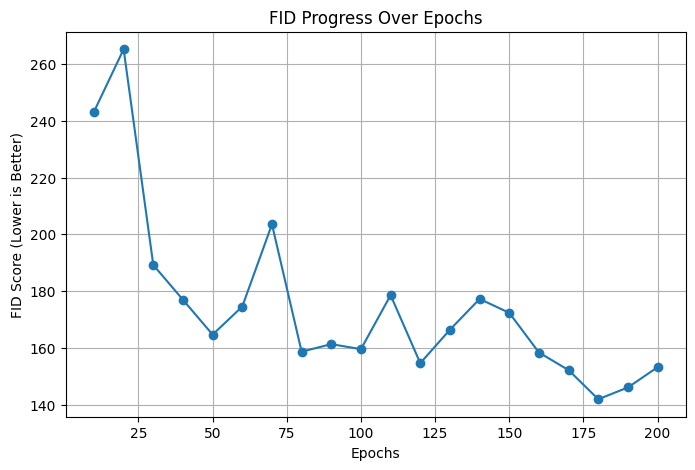

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(10, num_epochs+1, 10), fid_scores, marker='o')
plt.title("FID Progress Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("FID Score (Lower is Better)")
plt.grid(True)
plt.show()

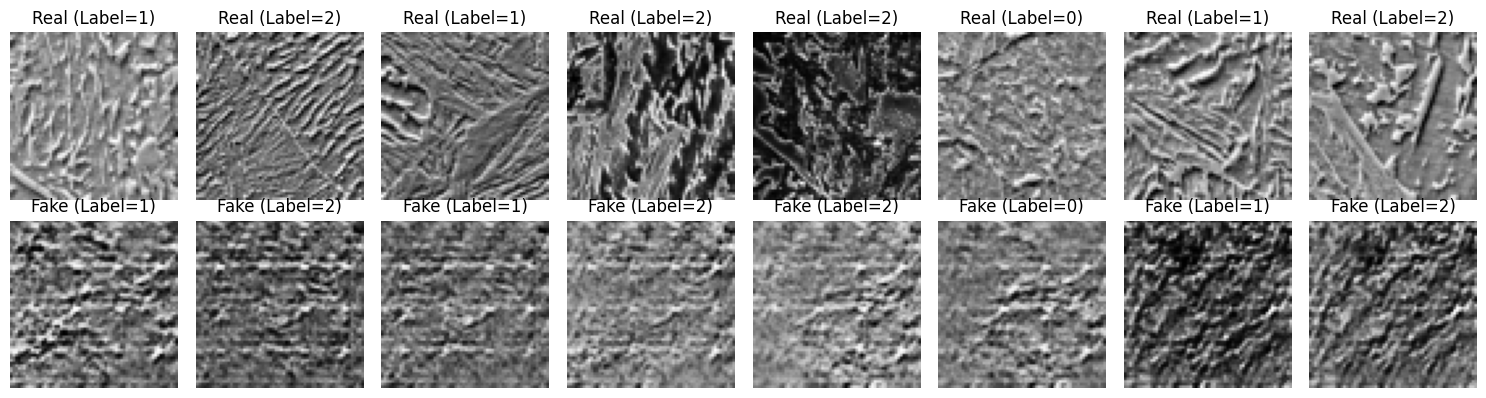

In [ ]:
fig, axes = plt.subplots(2, 8, figsize=(15, 4))
for i in range(8):
    axes[0, i].imshow(real_imgs[i].squeeze().cpu().numpy() * 0.5 + 0.5, cmap='gray')
    axes[0, i].set_title(f"Real (Label={labels[i].item()})")
    axes[0, i].axis('off')
    axes[1, i].imshow(fake_imgs[i].squeeze().detach().cpu().numpy() * 0.5 + 0.5, cmap='gray')
    axes[1, i].set_title(f"Fake (Label={labels[i].item()})")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
best_fid = min(fid_scores)
best_epoch = (fid_scores.index(best_fid) + 1) * 10  # because you computed FID every 10 epochs

print(f"\nBest FID Score: {best_fid:.2f} at Epoch {best_epoch}")

NameError: name 'fid_scores' is not defined

In [ ]:
checkpoint_dir = f"{base_dir}/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
best_G_path = f"{base_dir}/G_epoch_{best_epoch}.pth"
best_D_path = f"{base_dir}/D_epoch_{best_epoch}.pth"

NameError: name 'best_epoch' is not defined

In [ ]:
G.load_state_dict(torch.load(best_G_path))
D.load_state_dict(torch.load(best_D_path))

<All keys matched successfully>

In [ ]:
torch.save(G.state_dict(), f"{base_dir}/G_best_FID.pth")
torch.save(D.state_dict(), f"{base_dir}/D_best_FID.pth")

In [ ]:
torch.save({
    "epoch": num_epochs,
    "G_state_dict": G.state_dict(),
    "D_state_dict": D.state_dict(),
    "optimizerG": optimizerG.state_dict(),
    "optimizerD": optimizerD.state_dict(),
    "FID": fid_score
}, f"{checkpoint_dir}/cgan_final_checkpoint.pth")

In [ ]:
save_dir = "/content/drive/MyDrive/GAN/CGAN/results"

In [ ]:
report_dir = f"{save_dir}/report_samples"
os.makedirs(report_dir, exist_ok=True)

In [ ]:
G.eval()
with torch.no_grad():
    for label in range(num_classes):
        label_dir = os.path.join(report_dir, f"class_{label}")
        os.makedirs(label_dir, exist_ok=True)

        noise = torch.randn(16, nz, device=device)
        cond = one_hot(torch.full((16,), label, dtype=torch.long, device=device), num_classes, device)
        fake_imgs = G(noise, cond)

        # Save each image individually (like DCGAN)
        for i, img in enumerate(fake_imgs):
            save_image(img, f"{label_dir}/img_{i+1}.png", normalize=True)
        print(f"Saved 16 generated images for class {label}")

Saved 16 generated images for class 0
Saved 16 generated images for class 1
Saved 16 generated images for class 2


In [ ]:
summary_noise = torch.randn(num_classes * 8, nz, device=device)
summary_labels = torch.tensor([i % num_classes for i in range(num_classes * 8)], device=device)
summary_imgs = G(summary_noise, one_hot(summary_labels, num_classes, device))
grid = make_grid(summary_imgs, nrow=8, normalize=True)
save_image(grid, f"{report_dir}/summary_grid.png")
print(f"Summary grid saved at: {report_dir}/summary_grid.png")

Summary grid saved at: /content/drive/MyDrive/GAN/CGAN/results/report_samples/summary_grid.png


##CGAN Fine-Tuning with Hyperparameter Optimization

In [ ]:
checkpoint_dir = f"{base_dir}/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
checkpoint_path = f"{checkpoint_dir}/cgan_final_checkpoint.pth"

In [ ]:
checkpoint = torch.load(checkpoint_path, map_location=device)

In [ ]:
G.load_state_dict(checkpoint["G_state_dict"])
D.load_state_dict(checkpoint["D_state_dict"])

<All keys matched successfully>

In [ ]:
optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
optimizerG.load_state_dict(checkpoint["optimizerG"])
optimizerD.load_state_dict(checkpoint["optimizerD"])

In [ ]:
G = Generator(nz, nc, ngf, num_classes).to(device)
D = Discriminator(nc, ndf, num_classes).to(device)

optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
start_epoch = checkpoint["epoch"] + 1
best_fid = checkpoint["FID"]

In [ ]:
print(f"Loaded checkpoint from epoch {checkpoint['epoch']} with FID: {best_fid:.2f}")

Loaded checkpoint from epoch 200 with FID: 153.28


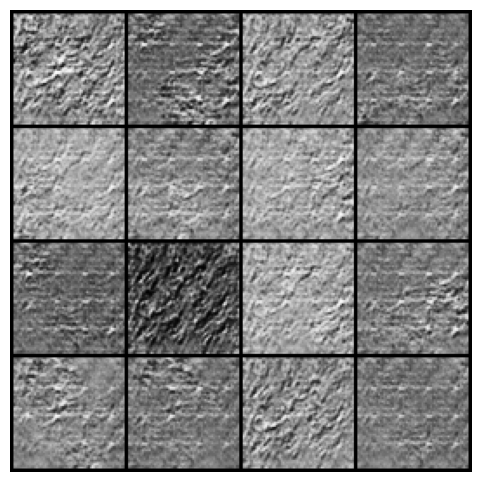

In [ ]:
# Random noise and labels
z = torch.randn(16, nz, device=device)
labels = torch.randint(0, num_classes, (16,), device=device)

# Convert labels to one-hot encoding
labels_onehot = F.one_hot(labels, num_classes=num_classes).float()

# Concatenate noise + label vectors
with torch.no_grad():
    fake_imgs = G(z, labels_onehot)

# Visualize
grid = make_grid(fake_imgs, nrow=4, normalize=True)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis("off")
plt.show()

Define Fine-Tuning Parameter Grid

In [ ]:
import gc

In [ ]:
param_grid = [
    {"lr_G": 5e-05, "lr_D": 0.0002, "beta1": 0.5, "beta2": 0.95, "label_smooth": 0.9},
    {"lr_G": 5e-05, "lr_D": 0.0002, "beta1": 0.6, "beta2": 0.95, "label_smooth": 0.9},
    {"lr_G": 0.0001, "lr_D": 0.0002, "beta1": 0.5, "beta2": 0.95, "label_smooth": 0.9},
]

In [ ]:
num_finetune_epochs = 4  # ↓ reduced from 10
fid_sample_limit = 200   # ↓ reduced from 500
best_fid, best_params = np.inf, None

In [ ]:
def compute_fid_score(G, dataloader, device):
    fid = FrechetInceptionDistance(feature=64).to(device)
    G.eval()
    total = 0
    with torch.no_grad():
        for real_imgs, labels in dataloader:
            if total >= fid_sample_limit: break
            real_imgs, labels = real_imgs.to(device), labels.to(device)
            b_size = real_imgs.size(0)
            z = torch.randn(b_size, nz, device=device)
            labels_onehot = F.one_hot(labels, num_classes=num_classes).float()
            fake_imgs = G(z, labels_onehot)
            real_uint8 = ((real_imgs * 0.5 + 0.5) * 255).to(torch.uint8).repeat(1,3,1,1)
            fake_uint8 = ((fake_imgs * 0.5 + 0.5) * 255).to(torch.uint8).repeat(1,3,1,1)
            fid.update(real_uint8, real=True)
            fid.update(fake_uint8, real=False)
            total += b_size
    return fid.compute().item()

Fine-Tuning Loop

In [ ]:
for i, params in enumerate(param_grid, start=1):
    print(f"\n[Trial {i}/{len(param_grid)}] {params}")
    G_trial = Generator(nz, nc, ngf, num_classes).to(device)
    D_trial = Discriminator(nc, ndf, num_classes).to(device)
    G_trial.load_state_dict(G.state_dict())
    D_trial.load_state_dict(D.state_dict())

    optimizerG = torch.optim.Adam(G_trial.parameters(), lr=params["lr_G"], betas=(params["beta1"], params["beta2"]))
    optimizerD = torch.optim.Adam(D_trial.parameters(), lr=params["lr_D"], betas=(params["beta1"], params["beta2"]))
    criterion = torch.nn.BCELoss()

    best_local_fid, patience = np.inf, 0

    for epoch in range(num_finetune_epochs):
        for real_imgs, labels in tqdm(dataloader, leave=False, desc=f"Trial {i} | Epoch {epoch+1}/{num_finetune_epochs}"):
            real_imgs, labels = real_imgs.to(device), labels.to(device)
            b_size = real_imgs.size(0)
            real_label = torch.full((b_size,), params["label_smooth"], device=device)
            fake_label = torch.zeros(b_size, device=device)

            # Train D
            optimizerD.zero_grad()
            z = torch.randn(b_size, nz, device=device)
            labels_onehot = F.one_hot(labels, num_classes=num_classes).float()
            fake_imgs = G_trial(z, labels_onehot)
            lossD_real = criterion(D_trial(real_imgs, labels).squeeze(), real_label)
            lossD_fake = criterion(D_trial(fake_imgs.detach(), labels).squeeze(), fake_label)
            lossD = lossD_real + lossD_fake
            lossD.backward()
            optimizerD.step()

            # Train G
            optimizerG.zero_grad()
            lossG = criterion(D_trial(fake_imgs, labels).squeeze(), real_label)
            lossG.backward()
            optimizerG.step()

        fid_score = compute_fid_score(G_trial, dataloader, device)
        print(f"Epoch {epoch+1} FID: {fid_score:.4f}")

        # Early stop if no improvement
        if fid_score < best_local_fid:
            best_local_fid, patience = fid_score, 0
            torch.save({
                "G_state_dict": G_trial.state_dict(),
                "params": params,
                "FID": fid_score
            }, f"{checkpoint_dir}/cgan_best_finetuned_colab.pth")
        else:
            patience += 1
            if patience >= 2:
                print("Early stopping — no FID improvement.")
                break

    if best_local_fid < best_fid:
        best_fid, best_params = best_local_fid, params
        print(" New global best fine-tuned model saved!")

    # Cleanup GPU memory between trials
    del G_trial, D_trial
    torch.cuda.empty_cache()
    gc.collect()

print("\n🏁 Fine-Tuning Complete!")
print(f" Best FID: {best_fid:.4f}")
print(f" Best Params: {best_params}")
print(" Model saved as cgan_best_finetuned_colab.pth")


[Trial 1/3] {'lr_G': 5e-05, 'lr_D': 0.0002, 'beta1': 0.5, 'beta2': 0.95, 'label_smooth': 0.9}


Epoch 1 FID: 37.7068


Epoch 2 FID: 22.7110


Epoch 3 FID: 16.1006


Epoch 4 FID: 19.9110
 New global best fine-tuned model saved!

[Trial 2/3] {'lr_G': 5e-05, 'lr_D': 0.0002, 'beta1': 0.6, 'beta2': 0.95, 'label_smooth': 0.9}


Epoch 1 FID: 39.6016


Epoch 2 FID: 59.1844


Epoch 3 FID: 87.0546
Early stopping — no FID improvement.

[Trial 3/3] {'lr_G': 0.0001, 'lr_D': 0.0002, 'beta1': 0.5, 'beta2': 0.95, 'label_smooth': 0.9}


Epoch 1 FID: 48.0623


Epoch 2 FID: 81.0761


Epoch 3 FID: 80.2947
Early stopping — no FID improvement.

🏁 Fine-Tuning Complete!
 Best FID: 16.1006
 Best Params: {'lr_G': 5e-05, 'lr_D': 0.0002, 'beta1': 0.5, 'beta2': 0.95, 'label_smooth': 0.9}
 Model saved as cgan_best_finetuned_colab.pth


In [ ]:
best_ckpt = torch.load(f"{checkpoint_dir}/cgan_best_finetuned_colab.pth", map_location=device)

In [ ]:
G.load_state_dict(best_ckpt["G_state_dict"])
best_params = best_ckpt["params"]
best_fid = best_ckpt["FID"]

In [ ]:
print(f"Loaded fine-tuned model | FID: {best_fid:.4f}")
print(f"Hyperparameters: {best_params}")

Loaded fine-tuned model | FID: 48.0623
Hyperparameters: {'lr_G': 0.0001, 'lr_D': 0.0002, 'beta1': 0.5, 'beta2': 0.95, 'label_smooth': 0.9}


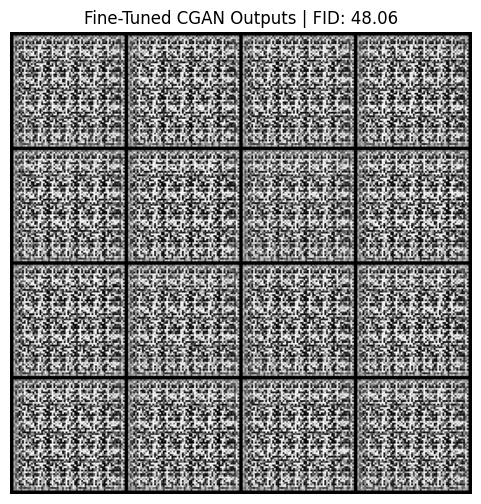

In [ ]:
G.eval()
z = torch.randn(16, nz, device=device)
labels = torch.arange(0, num_classes).repeat(6)[:16].to(device)
labels_onehot = F.one_hot(labels, num_classes=num_classes).float()

with torch.no_grad():
    fake_imgs = G(z, labels_onehot)

grid = make_grid(fake_imgs, nrow=4, normalize=True)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.title(f"Fine-Tuned CGAN Outputs | FID: {best_fid:.2f}")
plt.axis("off")
plt.show()

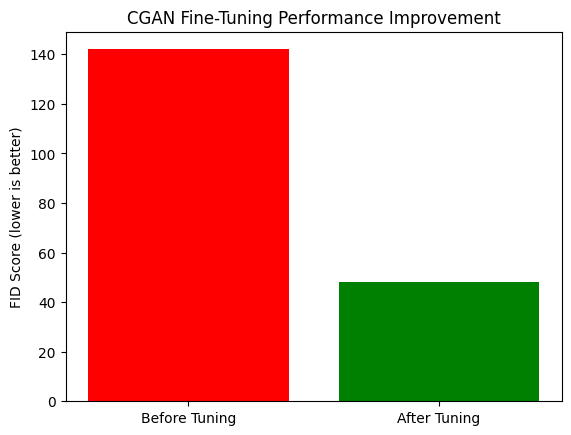

In [ ]:
fid_before = 142.01
fid_after = best_fid

plt.bar(["Before Tuning", "After Tuning"], [fid_before, fid_after], color=["red", "green"])
plt.ylabel("FID Score (lower is better)")
plt.title("CGAN Fine-Tuning Performance Improvement")
plt.show()